In [13]:
# Step 0: imports and seed
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

np.random.seed(42)


# Step 1: create 60 individuals split into 4 groups
n = 60
per_group = n // 4  # 15 each

groups = []
ages = []
avg_incomes = []
for group_idx in range(4):
    for i in range(per_group):
        if group_idx == 0:  # low income, young
            ages.append(int(np.random.normal(30, 3)))
            avg_incomes.append(int(np.random.normal(35000, 4000)))
            groups.append("low_young")
        elif group_idx == 1:  # low income, old
            ages.append(int(np.random.normal(60, 4)))
            avg_incomes.append(int(np.random.normal(34000, 4000)))
            groups.append("low_old")
        elif group_idx == 2:  # high income, young
            ages.append(int(np.random.normal(33, 3)))
            avg_incomes.append(int(np.random.normal(110000, 8000)))
            groups.append("high_young")
        else:  # high income, old
            ages.append(int(np.random.normal(62, 4)))
            avg_incomes.append(int(np.random.normal(115000, 8000)))
            groups.append("high_old")

df = pd.DataFrame(
    {"id": np.arange(n), "group": groups, "age": ages, "avg_income": avg_incomes}
)

df.head()


,id,group,age,avg_income
0,0,low_young,31,34446
1,1,low_young,31,41092
2,2,low_young,29,34063
3,3,low_young,34,38069
4,4,low_young,28,37170


# Sensitivity Metrics for Logistic Curve (Derivative Based Global Sensitivy Measurement (DGSM))

We define three sensitivity metrics based on the derivative of the logistic curve \(A(r)\) with respect to \(r\).

---

## 1. Current Metric: DGSM-like Average Squared Derivative
$$
\begin{equation}

S = \frac{1}{r_{\rm max} - r_{\rm min}} \int_{r_{\rm min}}^{r_{\rm max}} \left( \frac{dA}{dr} \right)^2 \, dr

\end{equation}
$$
- Emphasizes regions where the slope of \(A(r)\) is large.
- Sensitive to steep changes in the logistic curve.

---

## 2. Alternative Metric: Average Absolute Derivative
$$
\begin{equation}

S_{\rm abs} = \frac{1}{r_{\rm max} - r_{\rm min}} \int_{r_{\rm min}}^{r_{\rm max}} \left| \frac{dA}{dr} \right| \, dr
\end{equation}
$$

- Weights all slope magnitudes linearly.
- Less sensitive to extreme steep regions than the squared derivative.

---

## 3. Raw Average Derivative

$$
\begin{equation}
S_{\rm raw} = \frac{1}{r_{\rm max} - r_{\rm min}} \int_{r_{\rm min}}^{r_{\rm max}} \frac{dA}{dr} \, dr
\end{equation}
$$
- Measures the **average slope** across the domain.
- Can be close to zero if the curve has symmetric increase/decrease.


In [14]:
# Desired group beta means
target_betas = {
    "low_young": 1,
    "low_old": 5,
    "high_young": 10,
    "high_old": 20,
}

alpha_params = {}  # store α for each group

for group in df["group"].unique():
    df_g = df[df["group"] == group]

    # --- Natural random alpha1 and alpha2 per group ---
    alpha1 = np.random.normal(0.02, 0.005)      # age effect
    alpha2 = np.random.normal(1e-5, 3e-6)       # income effect

    # compute mean contribution from age & income
    mean_contrib = alpha1 * df_g["age"].mean() + alpha2 * df_g["avg_income"].mean()

    # --- Choose alpha0 so group mean β = target β ---
    alpha0 = target_betas[group] - mean_contrib

    alpha_params[group] = (alpha0, alpha1, alpha2)

# Compute individual β_i
def compute_beta(row):
    a0, a1, a2 = alpha_params[row["group"]]
    return a0 + a1 * row["age"] + a2 * row["avg_income"]

df["beta"] = df.apply(compute_beta, axis=1)

In [36]:
alpha_params["low_old"][0], alpha_params["low_old"][1], alpha_params["low_old"][2]

(np.float64(3.2103334023808685), 0.027013971554680497, 5.794446811623158e-06)

In [35]:
beat =  alpha_params["low_old"][0] + alpha_params["low_old"][2] *57  +alpha_params["low_old"][2] * 41409
beat

np.float64(3.4506059338716346)

In [17]:
df.groupby("group")["beta"].mean()

group
high_old      20.0
high_young    10.0
low_old        5.0
low_young      1.0
Name: beta, dtype: float64

/var/folders/6h/zs1rsngj0dnb85zy_kpstm140000gn/T/ipykernel_6705/2738977126.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(integrand, r) / (r[-1] - r[0])


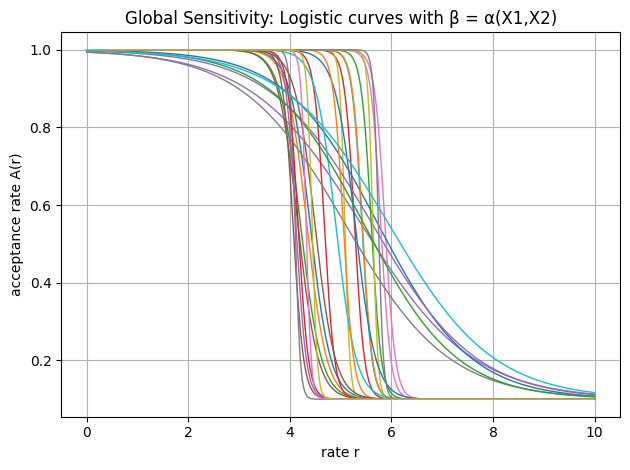

Global sensitivity S for each sampled curve:
group=low_old   , X1=    59.0, X2=32795.0, r0= 4.4 -> S_sq=6.7377e-02 --> beat =4.99
group=low_old   , X1=    64.0, X2=37725.0, r0= 4.3 -> S_sq=6.9581e-02 --> beat =5.16
group=low_old   , X1=    54.0, X2=34787.0, r0= 4.2 -> S_sq=6.5712e-02 --> beat =4.87
group=high_young, X1=    35.0, X2=120849.0, r0= 5.3 -> S_sq=1.3765e-01 --> beat =10.23
group=low_young , X1=    27.0, X2=29350.0, r0= 5.4 -> S_sq=1.2390e-02 --> beat =0.92
group=high_young, X1=    33.0, X2=94099.0, r0= 4.1 -> S_sq=1.3110e-01 --> beat =9.74
group=high_young, X1=    29.0, X2=100430.0, r0= 5.9 -> S_sq=1.3128e-01 --> beat =9.75
group=high_old  , X1=    62.0, X2=113123.0, r0= 4.1 -> S_sq=2.6705e-01 --> beat =19.99
group=high_old  , X1=    66.0, X2=121015.0, r0= 5.1 -> S_sq=2.6869e-01 --> beat =20.12
group=high_young, X1=    35.0, X2=120849.0, r0= 5.4 -> S_sq=1.3765e-01 --> beat =10.23
group=low_young , X1=    31.0, X2=41092.0, r0= 5.7 -> S_sq=1.4842e-02 --> beat =1.10
group=high_

In [69]:
def avg_derivative(r, A_vals, method="square"):
    """
    Compute sensitivity measure from derivative dA/dr.
    method:
        - "square": avg squared derivative (default)
        - "abs": avg absolute derivative
        - "raw": average derivative (may be close to zero if curve increases/decreases)
    """
    r = np.asarray(r)
    A_vals = np.asarray(A_vals)
    dA_dr = np.gradient(A_vals, r)
    
    if method == "square":
        integrand = dA_dr**2
    elif method == "abs":
        integrand = np.abs(dA_dr)
    elif method == "raw":
        integrand = dA_dr
    else:
        raise ValueError("Unknown method")
    
    return np.trapz(integrand, r) / (r[-1] - r[0])



def A_logistic_with_features(r, X1, X2, alpha0, alpha1, alpha2, r0_logistic, A_min, A_max):
    beta = alpha0 + alpha1 * X1 + alpha2 * X2
    r = np.asarray(r)
    return beta, (A_min + (A_max - A_min) / (1 + np.exp(beta * (r - r0_logistic))))



# Sample size
N = 30  # 

# Sample N actual individuals from the dataframe
df_sampled = df.sample(N, replace=True)
# df_sampled

sampled_X2  = df_sampled["avg_income"].values
sampled_X1  = df_sampled["age"].values
sampled_grp = df_sampled["group"].values


sampled_r0 = np.random.uniform(4, 6, N)

A_mins = np.full(N, 0.1)
A_maxs = np.full(N, 1.0)

# r-grid
r = np.linspace(0, 10, 500)


sensitivities_square = []
sensitivities_abs = []
sensitivities_avg = []
betas = []
# plt.figure(figsize=(6, 4))

# ---------------------------------------------------------------------
# Compute sensitivity for sampled parameter combinations
# ---------------------------------------------------------------------
for X1, X2, r0, grp, Amin, Amax in zip(sampled_X1, sampled_X2, sampled_r0,
                                      sampled_grp, A_mins, A_maxs):

    alpha0, alpha1, alpha2 = alpha_params[grp]
   


    beta_i, A_vals = A_logistic_with_features(r, X1, X2, alpha0, alpha1, alpha2, r0, Amin, Amax)

 
    sensitivities_square.append(avg_derivative(r, A_vals, method="square"))
    sensitivities_abs.append(avg_derivative(r, A_vals, method="abs"))
    sensitivities_avg.append(avg_derivative(r, A_vals, method="raw"))

    betas.append(beta_i)
    

    plt.plot(r, A_vals, linewidth=1)

plt.xlabel("rate r")
plt.ylabel("acceptance rate A(r)")
plt.title("Global Sensitivity: Logistic curves with β = α(X1,X2)")
plt.grid(True)
plt.tight_layout()
plt.show()

# print(f"beta {betas_arr} sensiti")

#---------------------------------------------------------------------
# Print results
#---------------------------------------------------------------------
print("Global sensitivity S for each sampled curve:")
for X1, X2, r0, grp, S, B in zip(sampled_X1, sampled_X2, sampled_r0,
                              sampled_grp, sensitivities_square, betas):
    print(
        f"group={grp:10s}, X1={X1:8.1f}, X2={X2:5.1f}, r0={r0:4.1f} -> S_sq={S:.4e} --> beat ={B:2.2f}"
    )


In [72]:
beta_arr = np.array(betas)
sens_arr_sqr = np.array(sensitivities_square)
sens_arr_abs = np.array(sensitivities_abs)
sens_arr_avg = np.array(sensitivities_avg)
groups_arr = np.array(sampled_grp)


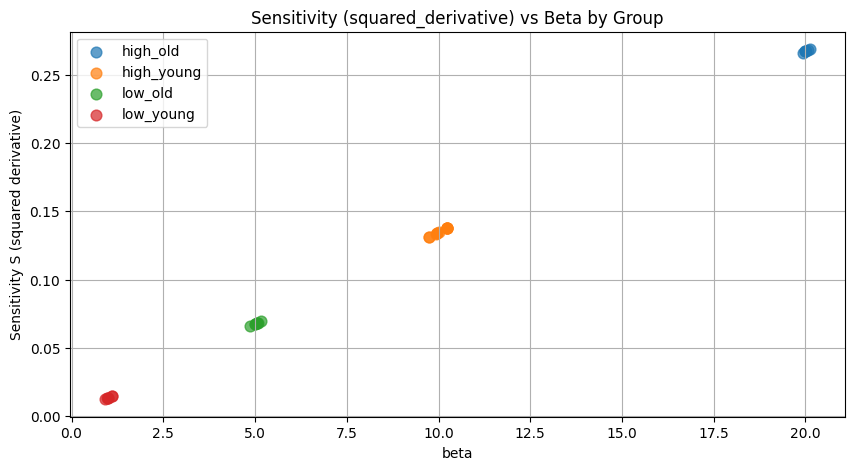

In [83]:
unique_groups = np.unique(groups_arr)

plt.figure(figsize=(10, 5))

for grp in unique_groups:
    mask = (groups_arr == grp)
    
    plt.scatter(
        beta_arr[mask],
        sens_arr_sqr[mask],
        label=grp,
        s=60,
        alpha=0.7
    )

plt.xlabel("beta")
plt.ylabel("Sensitivity S (squared derivative)")
plt.title("Sensitivity (squared_derivative) vs Beta by Group")
plt.legend()
plt.grid(True)

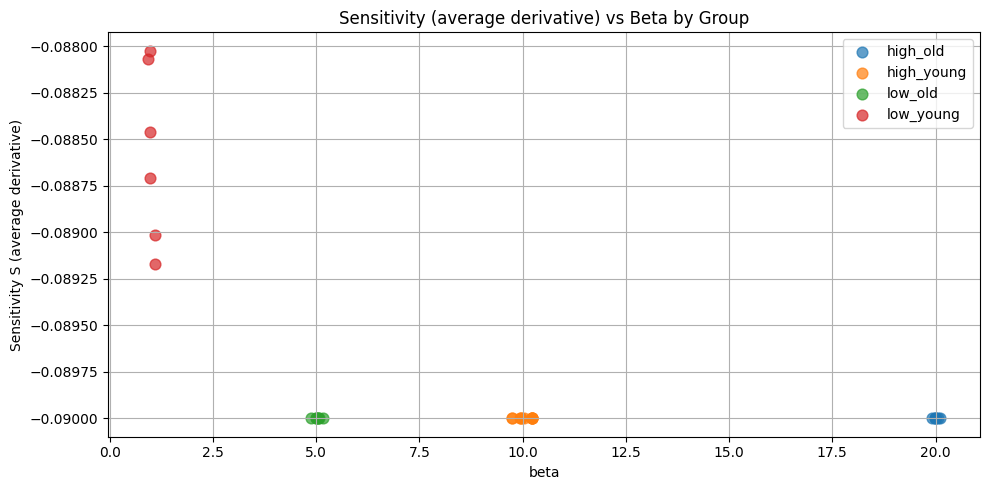

In [73]:
unique_groups = np.unique(groups_arr)

plt.figure(figsize=(10, 5))

for grp in unique_groups:
    mask = (groups_arr == grp)

    plt.scatter(
        beta_arr[mask],
        sens_arr_avg[mask],
        label=grp,
        s=60,
        alpha=0.7
    )

plt.xlabel("beta")
plt.ylabel("Sensitivity S (average derivative)")
plt.title("Sensitivity (average derivative) vs Beta by Group")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

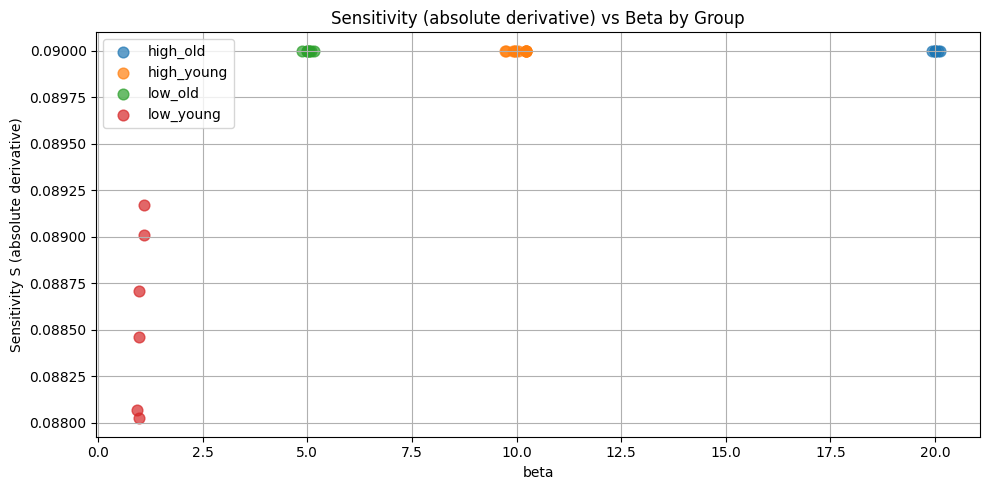

In [84]:
unique_groups = np.unique(groups_arr)

plt.figure(figsize=(10, 5))

for grp in unique_groups:
    mask = (groups_arr == grp)

    plt.scatter(
        beta_arr[mask],
        sens_arr_abs[mask],
        label=grp,
        s=60,
        alpha=0.7
    )

plt.xlabel("beta")
plt.ylabel("Sensitivity S (absolute derivative)")
plt.title("Sensitivity (absolute derivative) vs Beta by Group")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

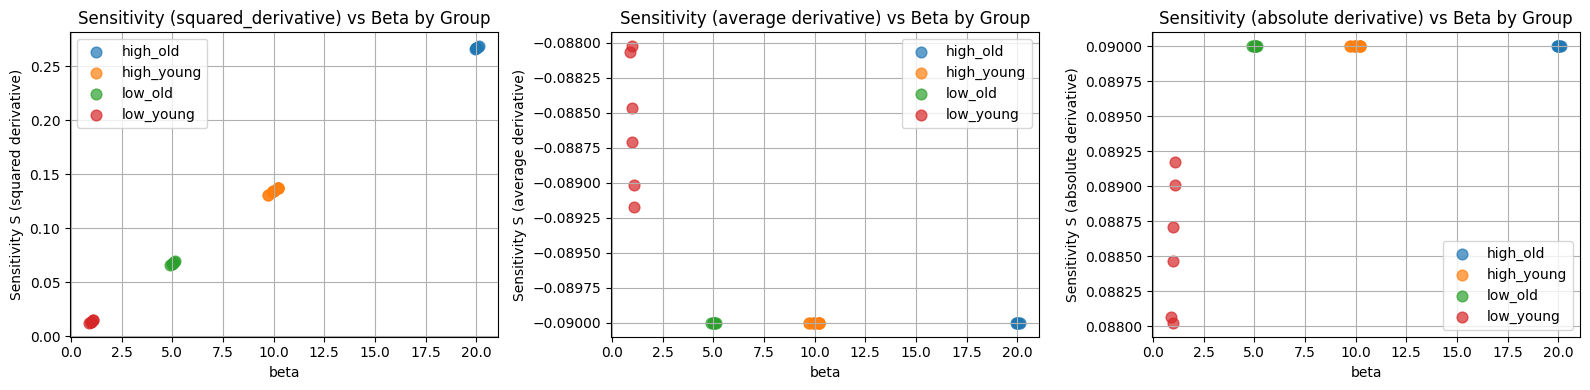

In [80]:
unique_groups = np.unique(groups_arr)

plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
for grp in unique_groups:
    mask = (groups_arr == grp)
    
    plt.scatter(
        beta_arr[mask],
        sens_arr_sqr[mask],
        label=grp,
        s=60,
        alpha=0.7
    )

plt.xlabel("beta")
plt.ylabel("Sensitivity S (squared derivative)")
plt.title("Sensitivity (squared_derivative) vs Beta by Group")
plt.legend()
plt.grid(True)


plt.subplot(1, 3, 2)
for grp in unique_groups:
    mask = (groups_arr == grp)
    plt.scatter(
        beta_arr[mask],
        sens_arr_avg[mask],
        label=grp,
        s=60,
        alpha=0.7
    )

plt.xlabel("beta")
plt.ylabel("Sensitivity S (average derivative)")
plt.title("Sensitivity (average derivative) vs Beta by Group")
plt.legend()
plt.grid(True)



plt.subplot(1, 3, 3)
for grp in unique_groups:
    mask = (groups_arr == grp)
    plt.scatter(
        beta_arr[mask],
        sens_arr_abs[mask],
        label=grp,
        s=60,
        alpha=0.7
    )

plt.xlabel("beta")
plt.ylabel("Sensitivity S (absolute derivative)")
plt.title("Sensitivity (absolute derivative) vs Beta by Group")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

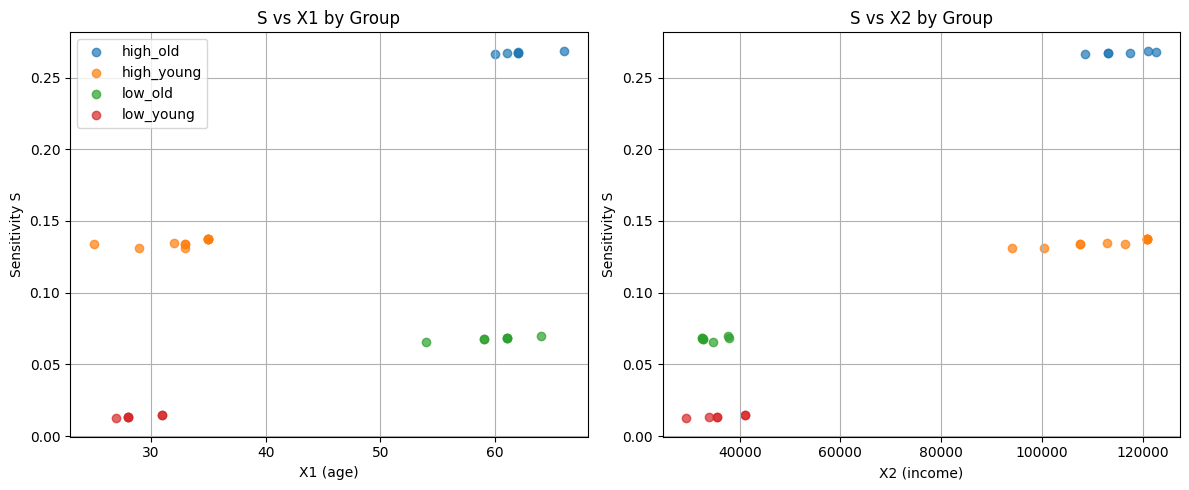

In [75]:
unique_groups = np.unique(groups_arr)

plt.figure(figsize=(12, 5))

# ----- X1 -----
plt.subplot(1, 2, 1)
for grp in unique_groups:
    mask = (groups_arr == grp)
    plt.scatter(sampled_X1[mask], sens_arr_sqr[mask], label=grp, alpha=0.7)
plt.xlabel("X1 (age)")
plt.ylabel("Sensitivity S")
plt.title("S vs X1 by Group")
plt.grid(True)
plt.legend()

# ----- X2 -----
plt.subplot(1, 2, 2)
for grp in unique_groups:
    mask = (groups_arr == grp)
    plt.scatter(sampled_X2[mask], sens_arr_sqr[mask], label=grp, alpha=0.7)
plt.xlabel("X2 (income)")
plt.ylabel("Sensitivity S")
plt.title("S vs X2 by Group")
plt.grid(True)

plt.tight_layout()
plt.show()